In [2]:
from datasets import load_dataset
from token_shap import TokenSHAP
from nltk.corpus import words
from termcolor import colored
import random
import nltk

In [3]:
nltk.download('words')

[nltk_data] Downloading package words to /home/ronig/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [9]:
def inject_random_words(prompts, injection_rate=(0.2, 0.3)):
    word_list = words.words()
    injected_prompts = []
    dict_injected = {}
    for prompt in prompts:
        words_in_prompt = prompt.split()
        num_injections = int(len(words_in_prompt) * random.uniform(*injection_rate))
        injection_indices = random.sample(range(len(words_in_prompt) + 1), num_injections)
        random_words = []
        for index in sorted(injection_indices, reverse=True):
            random_word = random.choice(word_list)
            words_in_prompt.insert(index, random_word)
            random_words.append(random_word)
        injected_prompts.append(' '.join(words_in_prompt))
        dict_injected[prompt] = random_words
    return injected_prompts, dict_injected

def color_injected_words(original_prompts, injected_prompts, n):
    for _ in range(n):
        idx = random.randint(0, len(original_prompts) - 1)
        original_words = set(original_prompts[idx].split())
        injected_words = injected_prompts[idx].split()
        
        colored_prompt = []
        for word in injected_words:
            if word not in original_words:
                colored_prompt.append(colored(word, 'red'))
            else:
                colored_prompt.append(word)
        
        print(' '.join(colored_prompt))

In [10]:
ds = load_dataset("tatsu-lab/alpaca")

In [11]:
prompts = random.sample(ds['train']['instruction'], 10)

In [12]:
injected_prompts, dict_injected = inject_random_words(prompts)

In [14]:
color_injected_words(prompts, injected_prompts, 3)

Edit the sentence making sure demnition that ponderableness all ikey pronouns used are grammatically correct.
Convert the semigala given anthracomartian text in the input to a JSON format.
Manchester Analyze natator the effects of climate change on food production.


/opt/anaconda3/envs/opensora/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/srv/jupyterhub/research/ronig/TokenSHAP/token_shap.py:114: RuntimeWarning: invalid value encountered in scalar divide
  norm_value = (value - min(shapley_values.values())) / (max(shapley_values.values()) - min(shapley_values.values()))


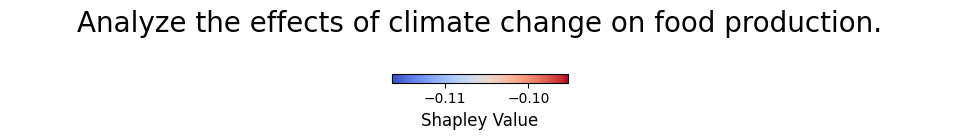

/srv/jupyterhub/research/ronig/TokenSHAP/token_shap.py:114: RuntimeWarning: invalid value encountered in scalar divide
  norm_value = (value - min(shapley_values.values())) / (max(shapley_values.values()) - min(shapley_values.values()))


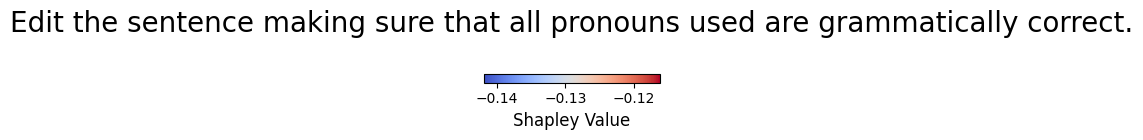

/srv/jupyterhub/research/ronig/TokenSHAP/token_shap.py:114: RuntimeWarning: invalid value encountered in scalar divide
  norm_value = (value - min(shapley_values.values())) / (max(shapley_values.values()) - min(shapley_values.values()))


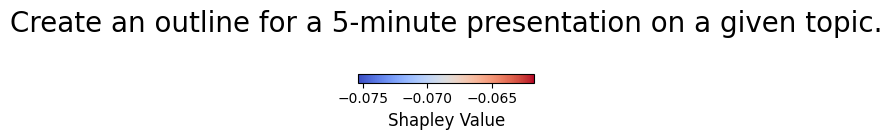

In [ ]:
%%time
# Initialize TokenSHAP with your model & tokenizer
model_name = "llama3"
tshap = TokenSHAP(model_name, tokenizer_path = "NousResearch/Hermes-2-Theta-Llama-3-8B")
dict_shap_values = {}
for prompt in prompts:
    results = tshap.analyze(prompt, sampling_ratio = 0.3, splitter = ' ')
    dict_shap_values[prompt] = tshap.shapley_values

In [ ]:
with open('dict_shap_values.pkl', 'wb') as file:
    pickle.dump(dict_shap_values, file)

In [ ]:
dict_shap_values